In [1]:
import numpy as np  
from pathlib import Path
import json
import time 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist, pdist, squareform

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import helper           
import clustering

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',] * 10
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',] * 10 
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '*', '+', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
linestyles = ["-", "--", "-."]


In [2]:
# load and unpack parameters
# make sure to change out_path and out_param_path simultaneously
seed = "499"
task = "everything"
hidden = "150"
batch = "128"
# this file might be large, for the sake of completeness
out_path_name = "multiple_tasks/" + f"param_{task}_seed{seed}_inputtrain+Wtrain+yesoversample+hidden{hidden}+batch{batch}_result.npz"
out_path = Path(out_path_name)

size_bytes = out_path.stat().st_size  
size_gb = size_bytes / 1024**3 
print(f"{out_path} = {size_gb:.3f} GiB")

with np.load(out_path_name, allow_pickle=True) as data:
    rules_epochs = data["rules_epochs"].item()
    hyp_dict = data["hyp_dict"].item()
    all_rules = data["all_rules"]
    test_task = data["test_task"]
    # Ms = data["Ms"]
    Ms_orig = data["Ms_orig"]
    hs = data["hs"]
    bs = data["bs"]
    xs = data["xs"]

print(f"Ms_orig: {Ms_orig.shape}")
print(f"hs: {hs.shape}")
print(f"xs: {xs.shape}")

out_param_path = "multiple_tasks/" + f"param_{task}_seed{seed}_inputtrain+Wtrain+yesoversample+hidden{hidden}+batch{batch}_param.json"
out_param_path = Path(out_param_path)

with out_param_path.open() as f: 
    raw_cfg_param = json.load(f)

task_params, train_params, net_params = raw_cfg_param["task_params"], raw_cfg_param["train_params"], raw_cfg_param["net_params"]

multiple_tasks/param_everything_seed499_inputtrain+Wtrain+yesoversample+hidden150+batch128_result.npz = 0.899 GiB
Ms_orig: (300, 95, 150, 150)
hs: (300, 95, 150)
xs: (300, 95, 150)


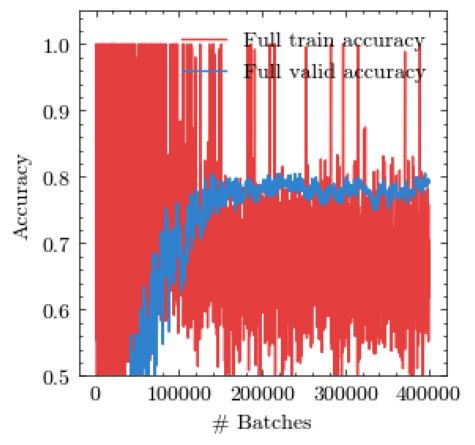

In [3]:
from pathlib import Path
from PIL import Image

def find_pngs_with_components(root, components, recursive=True, case_sensitive=False):
    """
    Return a list of Paths to .png files whose *filenames* contain all substrings in `components`.
    """
    root = Path(root)
    if not case_sensitive:
        components = [c.lower() for c in components]

    candidates = root.rglob("*.png") if recursive else root.glob("*.png")
    matches = []
    for p in candidates:
        name = p.name if case_sensitive else p.name.lower()
        if all(c in name for c in components):
            matches.append(p)

    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches

def show_image(path):
    img = Image.open(path)
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(img)
    ax.axis('off')
    fig.show()

search_root = "./multiple_tasks/"
components = ["loss", f"seed{seed}"]    

matches = find_pngs_with_components(search_root, components,
                                    recursive=True, case_sensitive=False)
show_image(matches[0])

clustering_name: input
cell_vars_rules_sorted_norm: (49, 150)
clustering_name: hidden
cell_vars_rules_sorted_norm: (49, 150)


AttributeError: 'numpy.ndarray' object has no attribute 'suptitle'

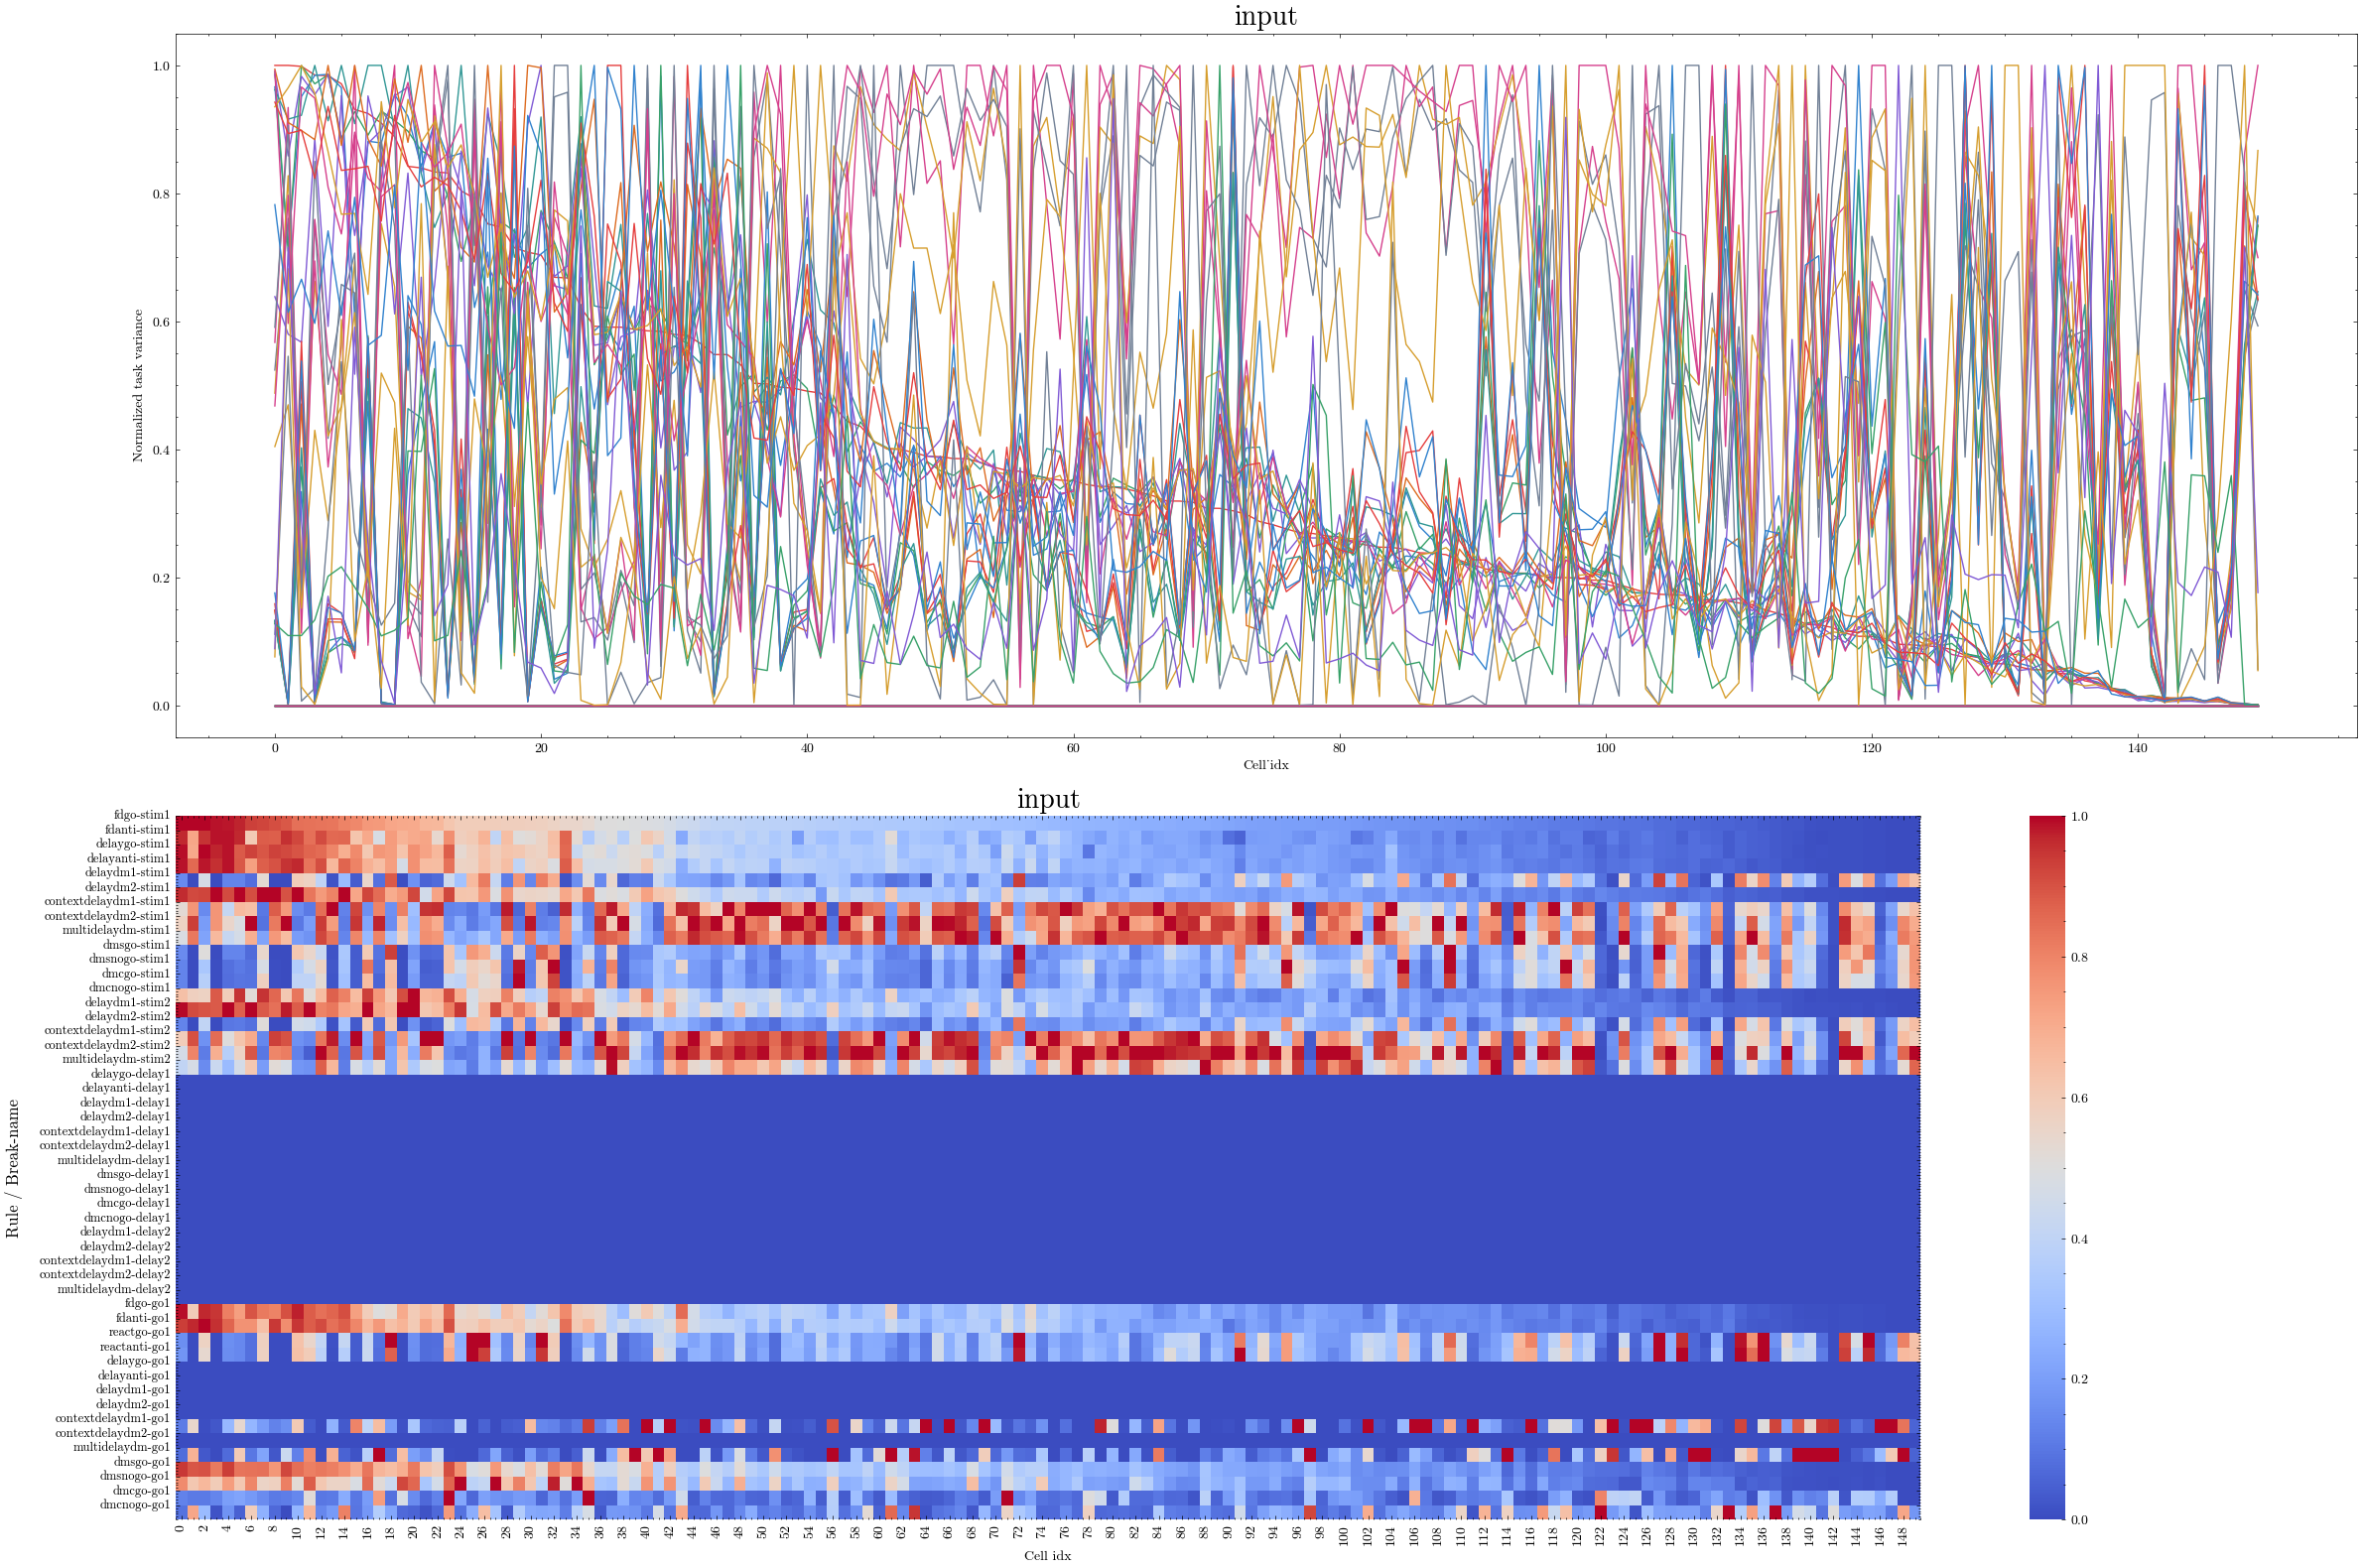

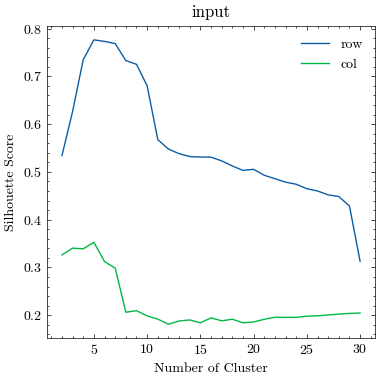

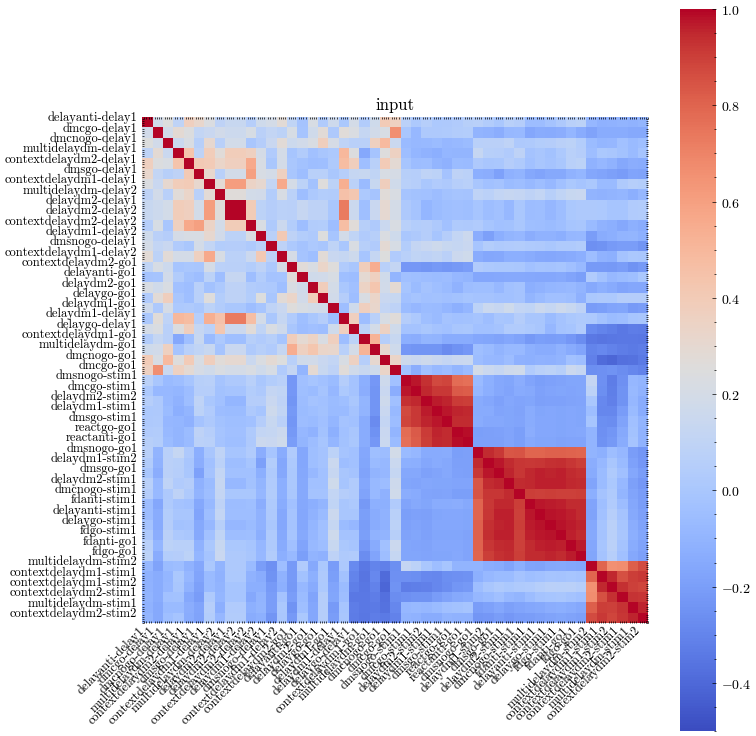

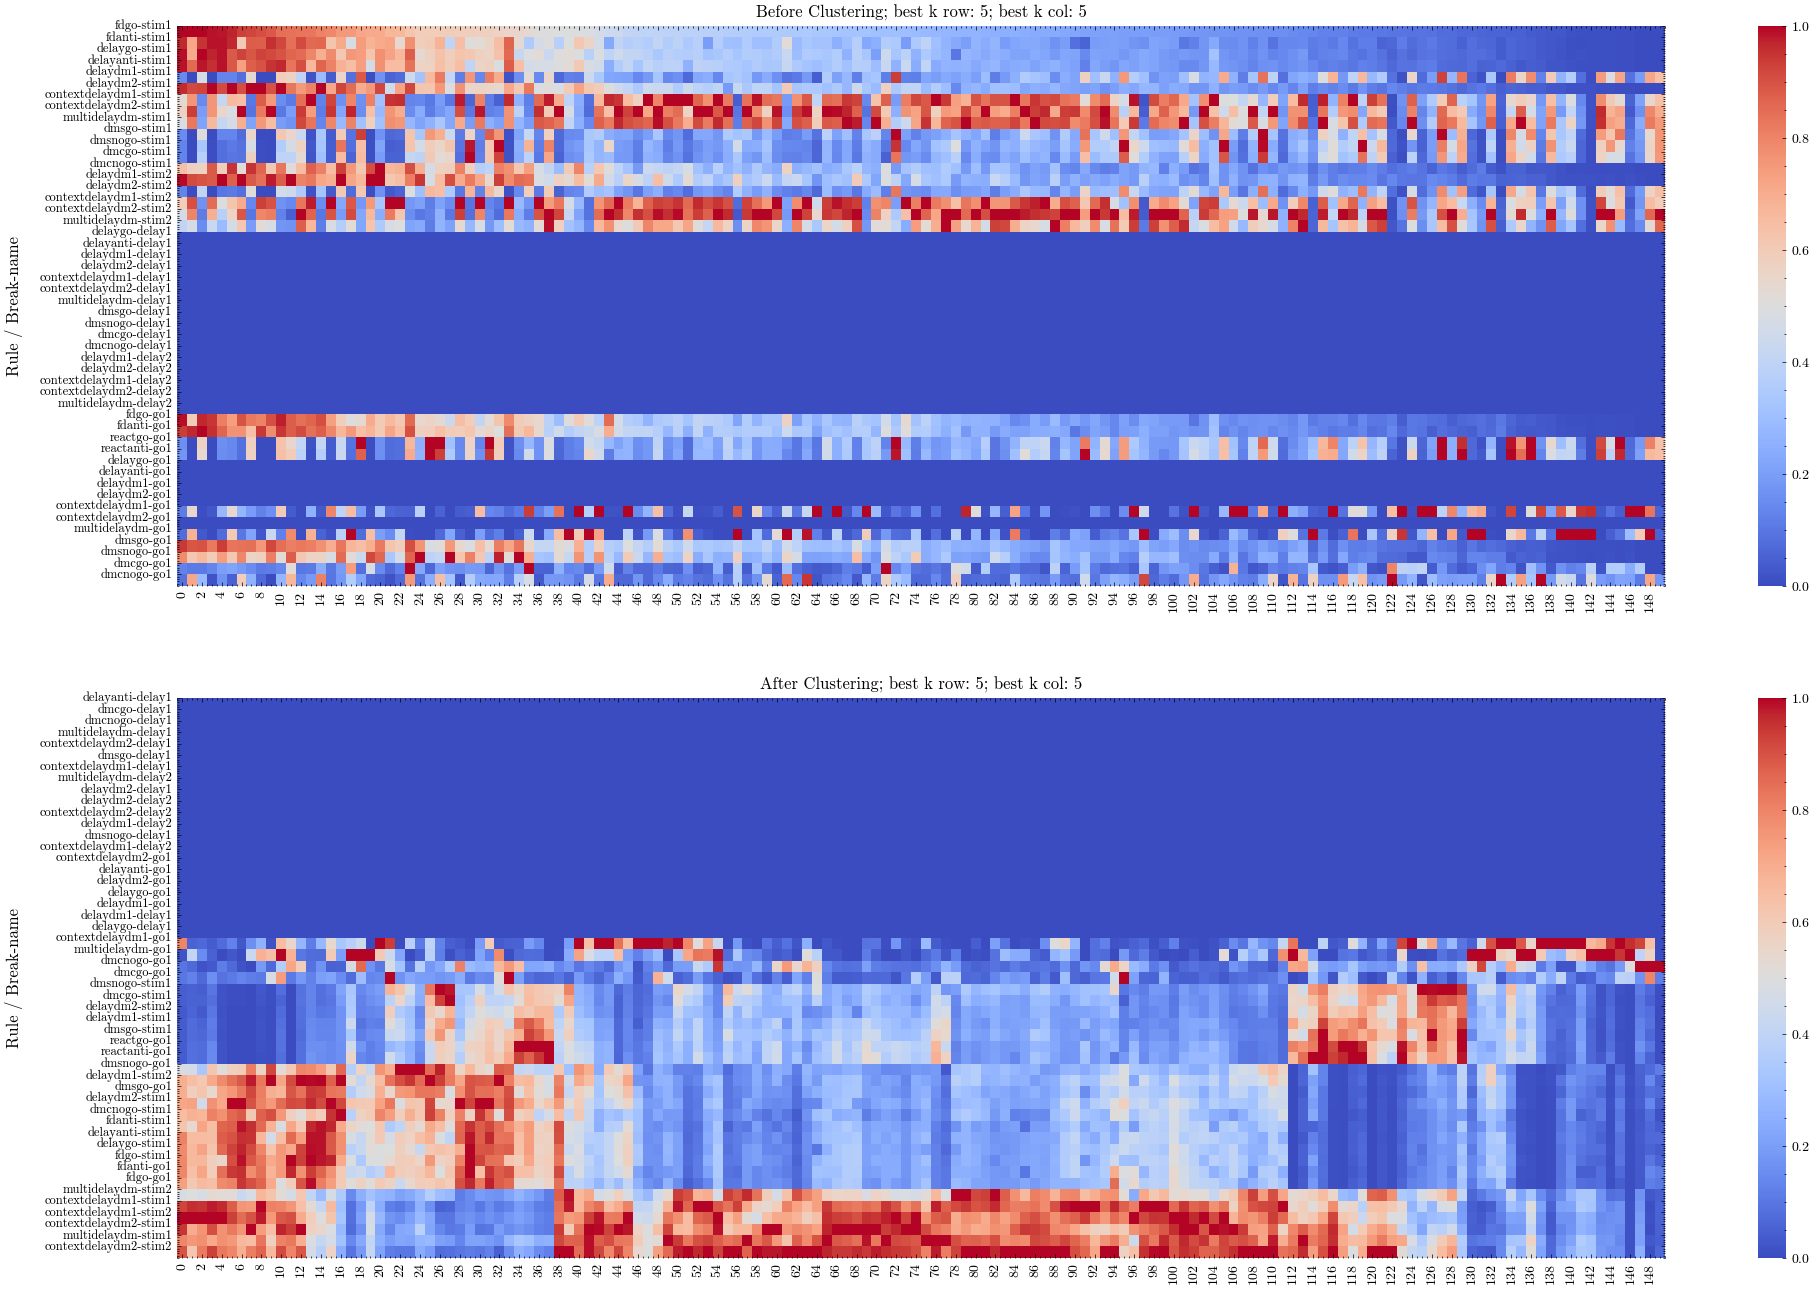

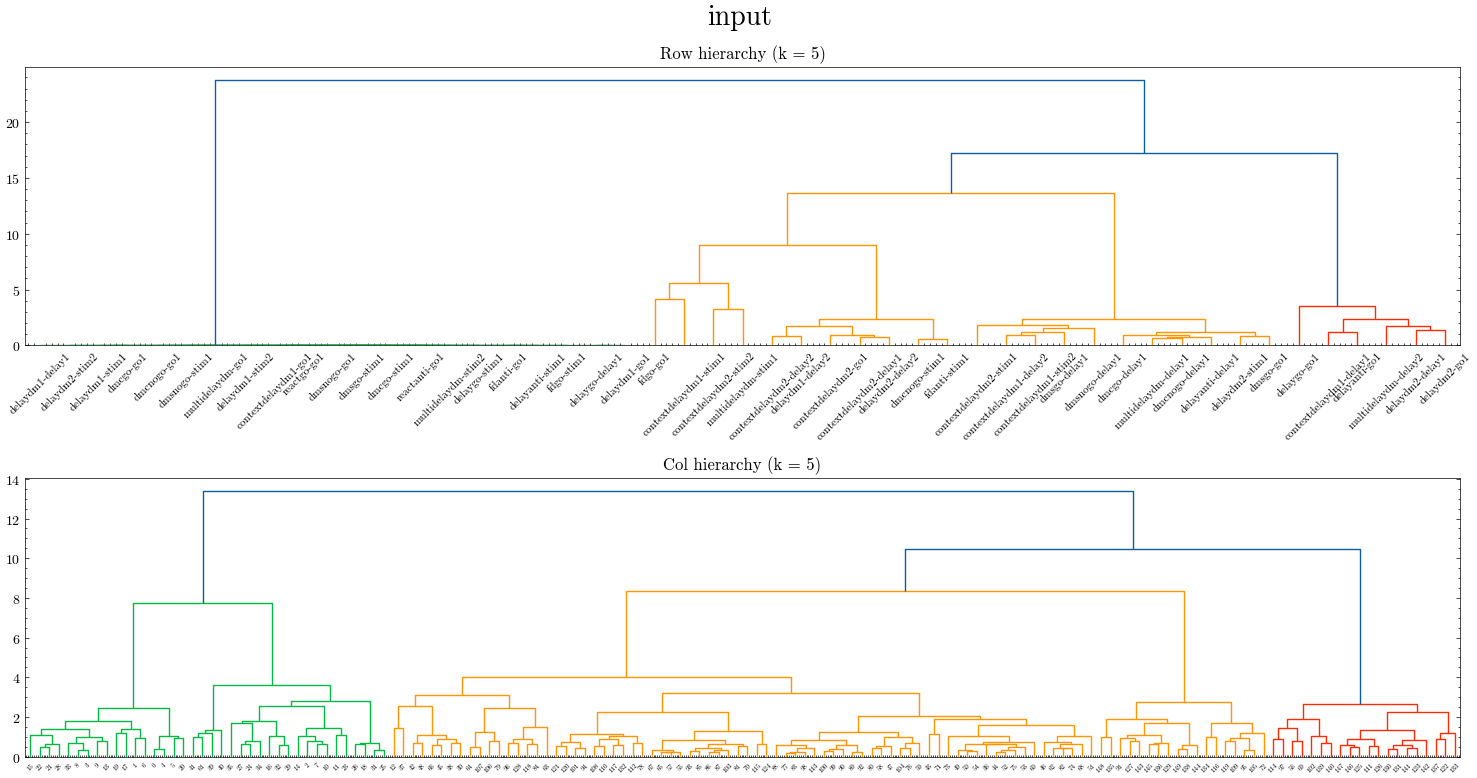

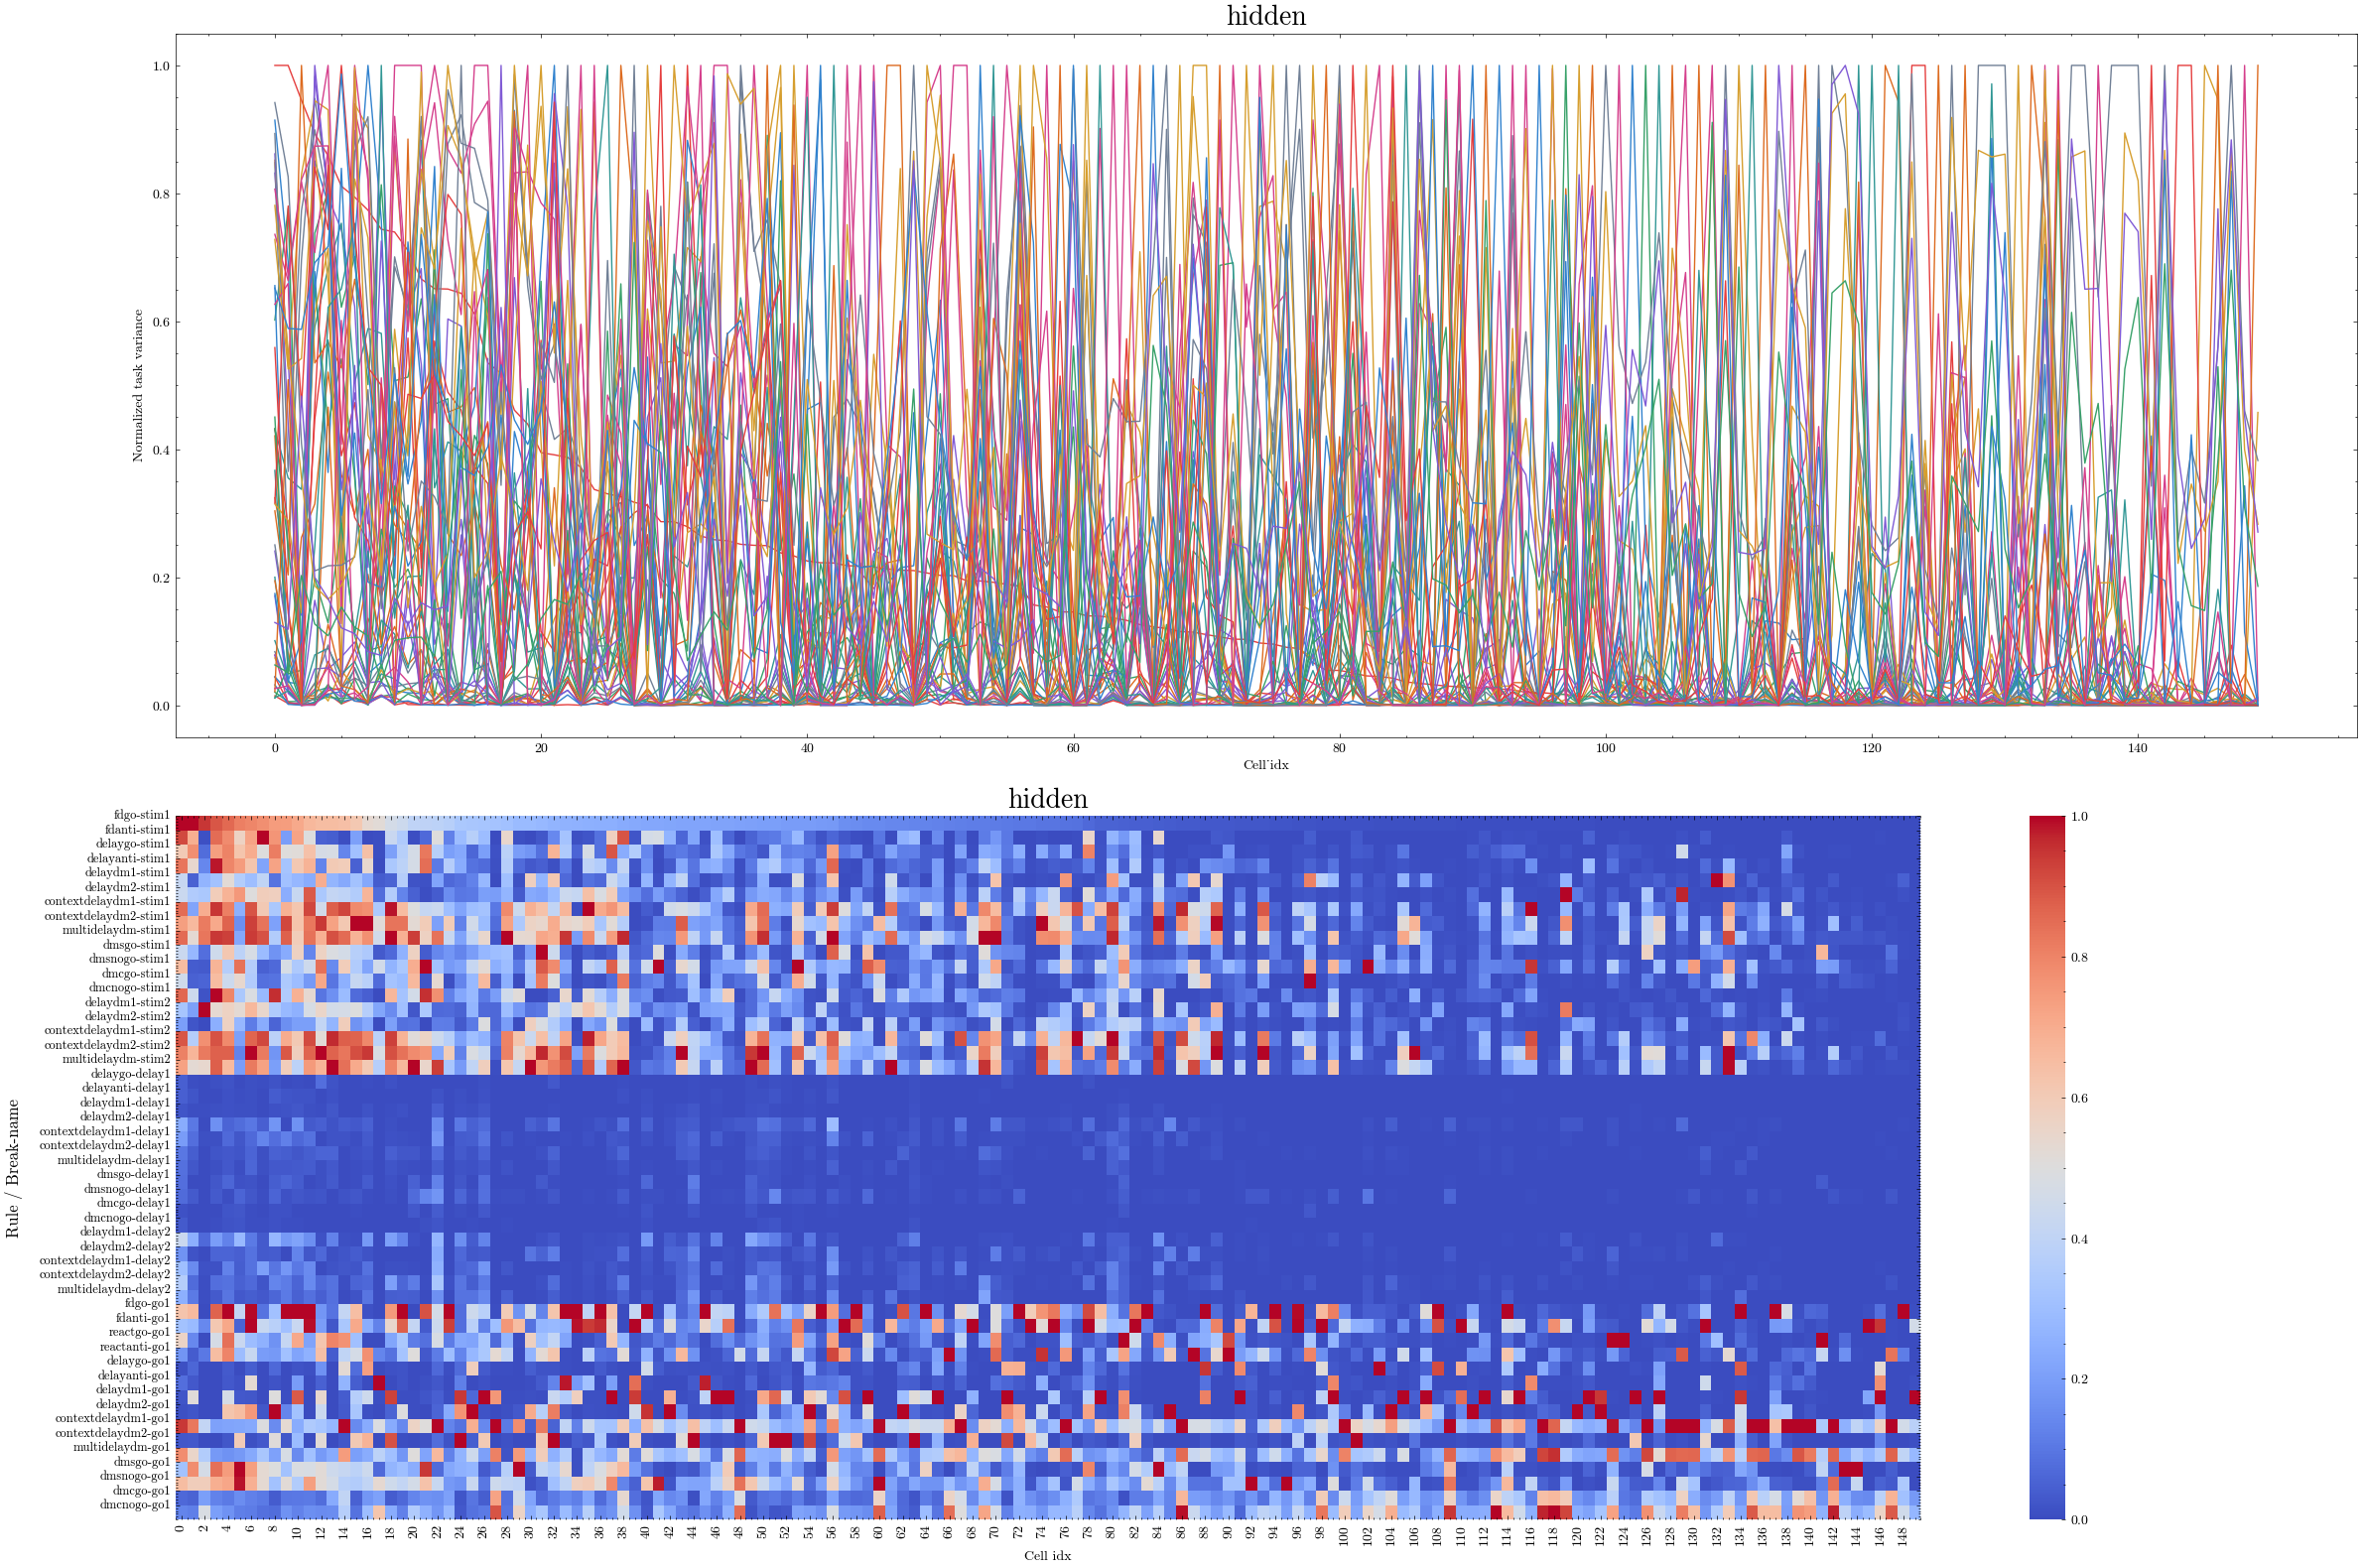

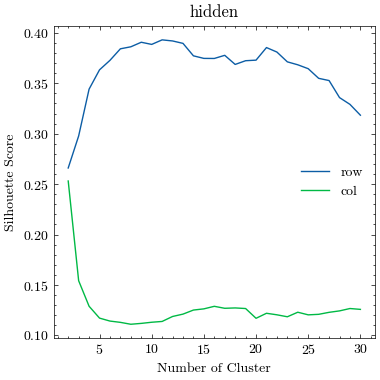

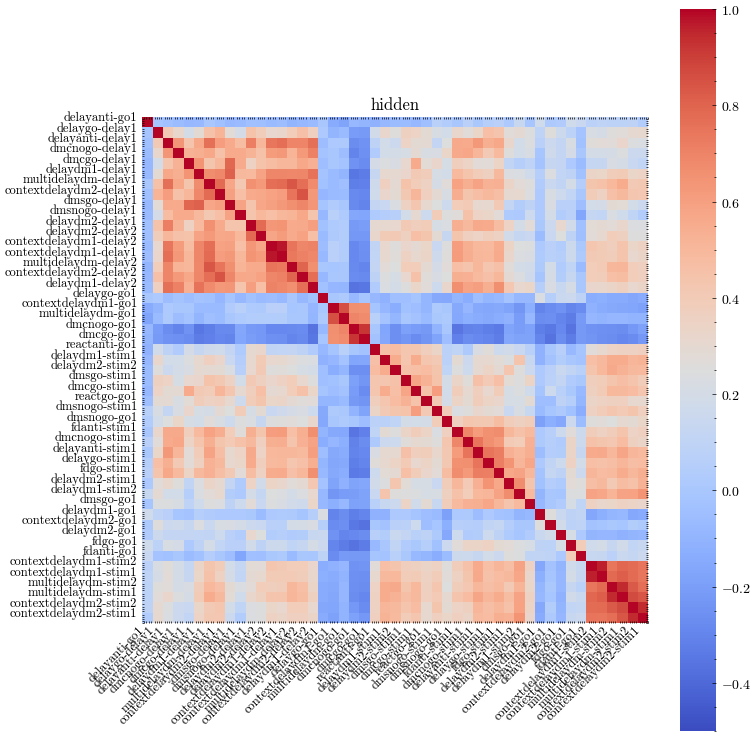

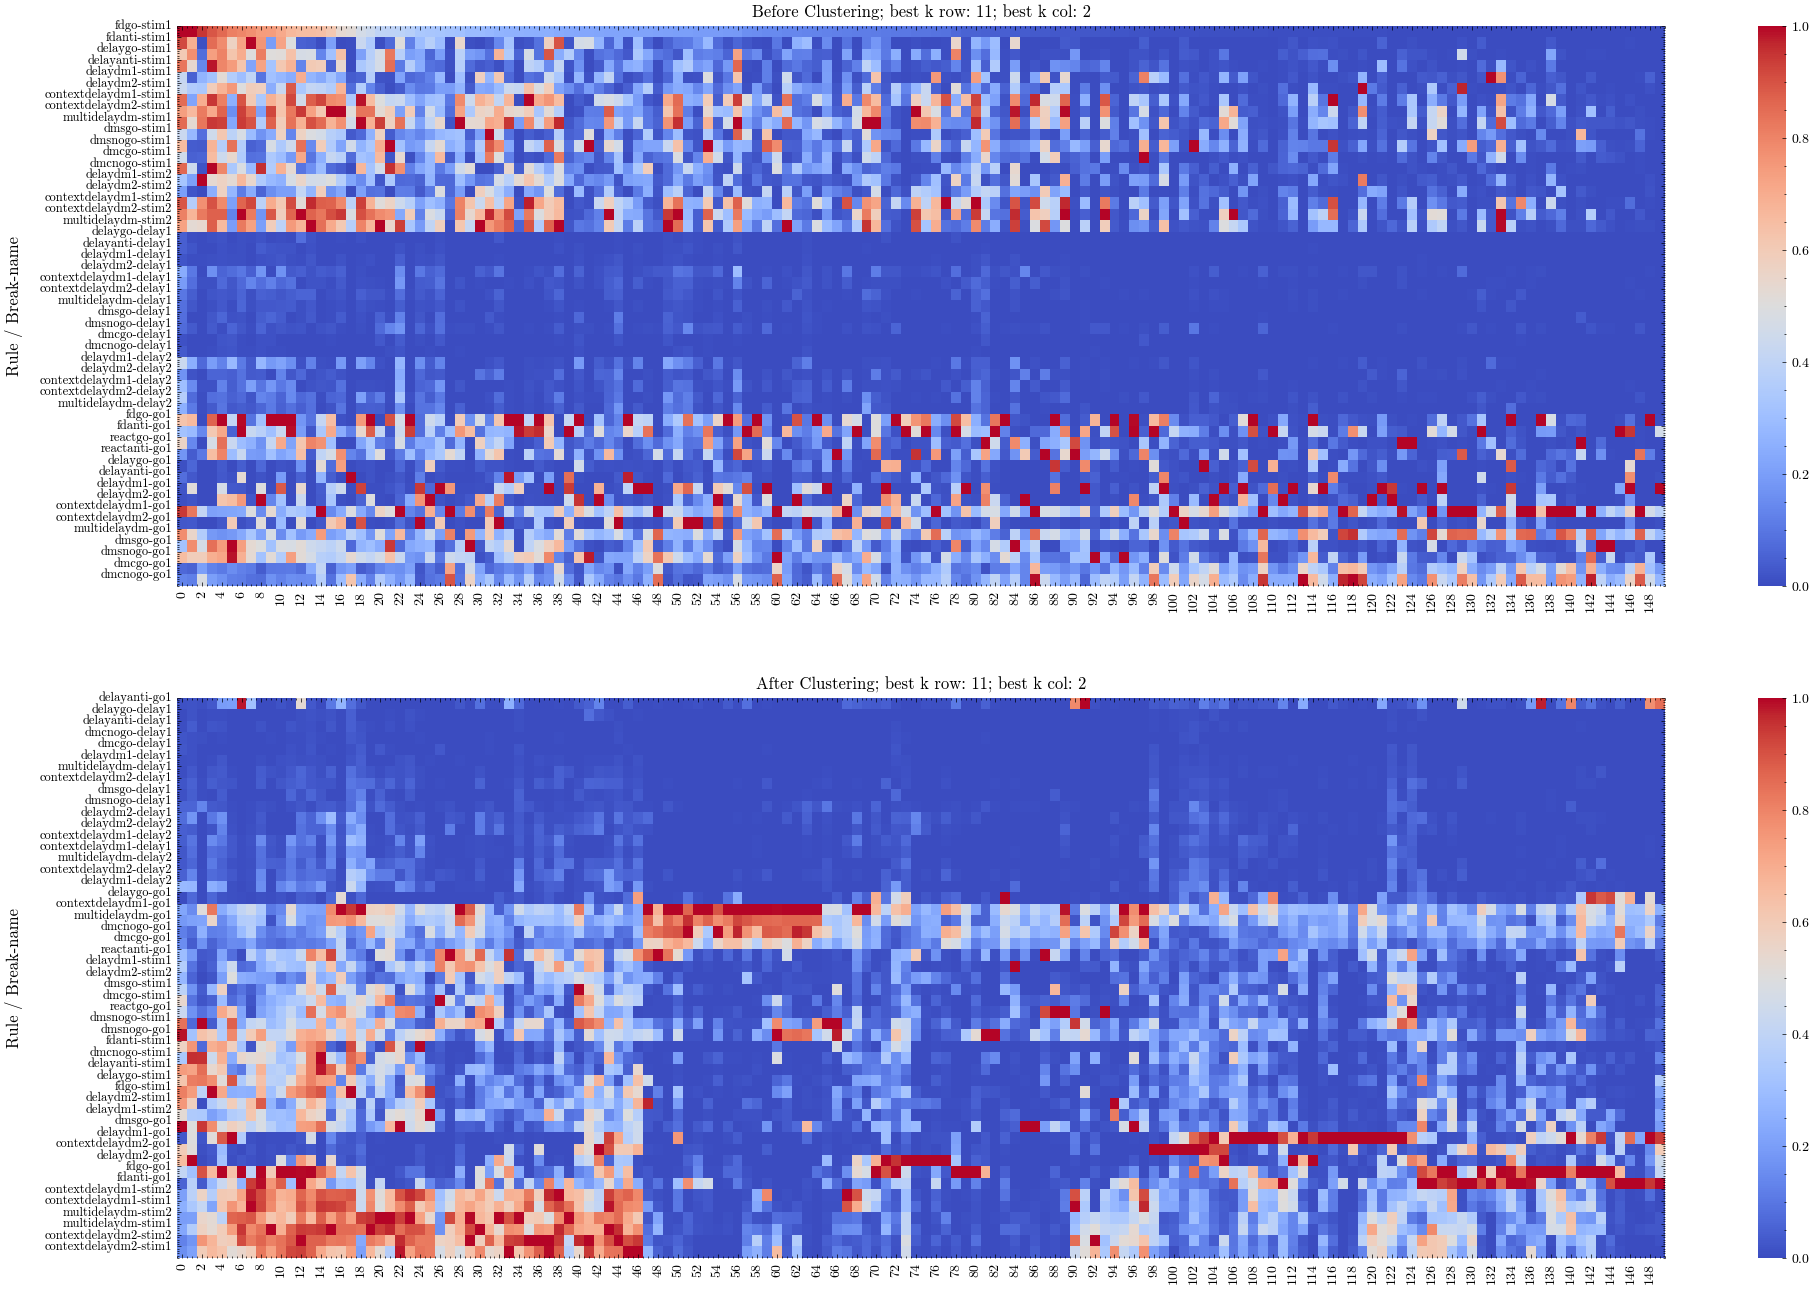

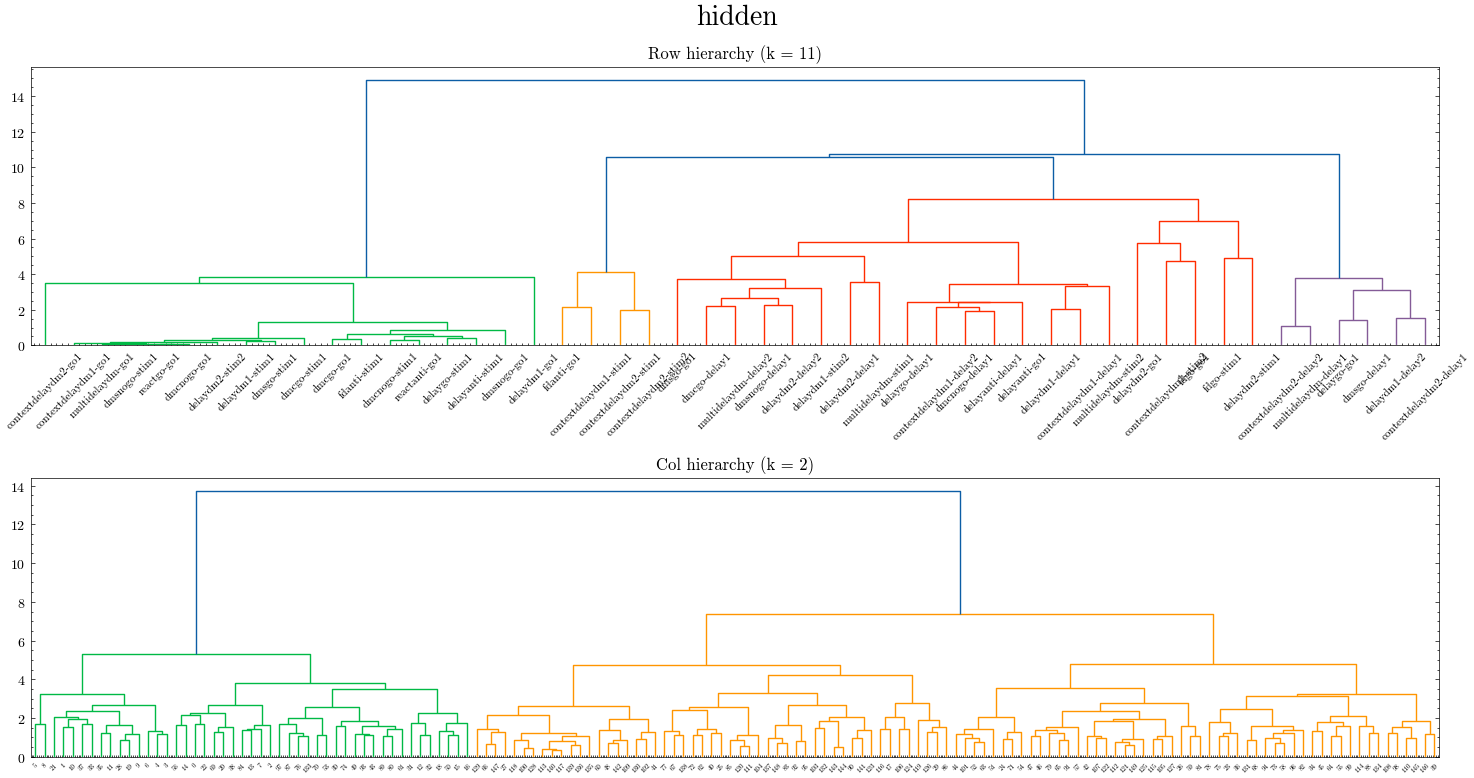

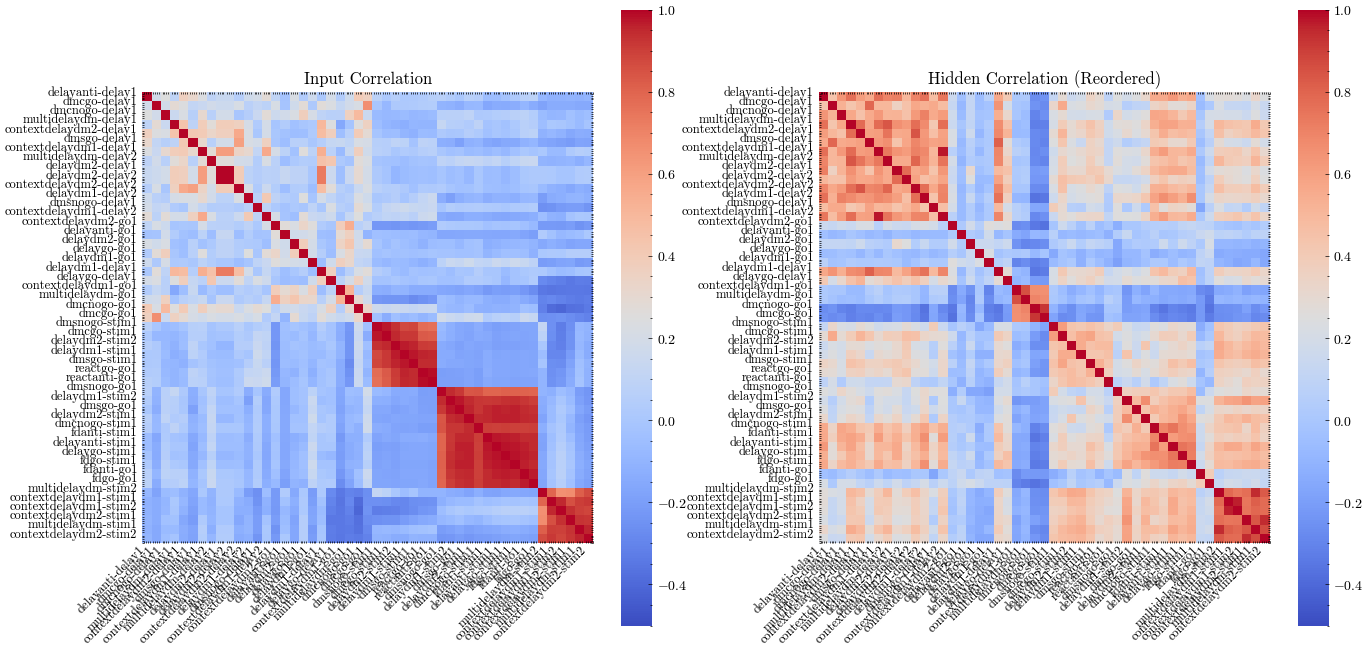

In [6]:
# clustering_data_analysis = [xs, hs, Ms_orig]
# clustering_data_analysis_names = ["input", "hidden", "modulation_all"]

clustering_data_analysis = [xs, hs]
clustering_data_analysis_names = ["input", "hidden"]

clustering_data_hierarchy = {}
clustering_corr_info = []

for clustering_index in range(len(clustering_data_analysis)): 
    clustering_data = clustering_data_analysis[clustering_index]
    clustering_name = clustering_data_analysis_names[clustering_index]
    print(f"clustering_name: {clustering_name}")
    
    if hyp_dict['ruleset'] == "everything": 
        phase_to_indices = [
            ("stim1",  [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
            ("stim2",  [6, 7, 8, 9, 10]),
            ("delay1", [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
            ("delay2", [6, 7, 8, 9, 10]),
            ("go1",    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
        ]
    elif hyp_dict['ruleset'] == "contextdelaydm1":
        phase_to_indices = [
            ("stim1", [0]), 
            ("stim2", [0]), 
            ("delay1", [0]), 
            ("delay2", [0]), 
            ("go1", [0]), 
        ]

    elif hyp_dict['ruleset'] == "delaydm1":
        phase_to_indices = [
            ("stim1", [0]), 
            ("stim2", [0]), 
            ("delay1", [0]), 
            ("delay2", [0]), 
            ("go1", [0]), 
        ]

    elif hyp_dict['ruleset'] == "dmcgo":
        phase_to_indices = [
            ("stim1", [0]), 
            ("delay1", [0]), 
            ("go1", [0]), 
        ]
    
    tb_break = [
        [idx, rules_epochs[all_rules[idx]][phase]]
        for phase, indices in phase_to_indices
        for idx in indices
    ]
    
    tb_break_name = [
        f"{all_rules[idx]}-{phase}"
        for phase, indices in phase_to_indices
        for idx in indices
    ]
    
    tb_break_name = np.array(tb_break_name)
    
    cell_vars_rules = [] 
    
    for el in range(len(tb_break)):
        n_rules = len(task_params['rules'])
        n_cells = clustering_data.shape[-1]
            
        rule_idx, period_time = tb_break[el][0], tb_break[el][1]
        
        # print('Rule {} (idx {})'.format(all_rules[rule_idx], rule_idx))
        if len(clustering_data.shape) == 3:
            rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1], :]
            cell_vars_rules.append(np.var(rule_cluster, axis=(0, 1))) 
        else:
            clustering_data_old = clustering_data
            # calculate the mean value based on input
            if "pre" in clustering_name:
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1]]
                mean_var = np.var(rule_cluster, axis=(0, 1)).mean(axis=0)
                cell_vars_rules.append(mean_var)
                
            elif "post" in clustering_name: 
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1]]
                mean_var = np.var(rule_cluster, axis=(0, 1)).mean(axis=1)
                cell_vars_rules.append(mean_var)
                
            elif "all" in clustering_name: 
                clustering_data = clustering_data.reshape(clustering_data.shape[0], clustering_data.shape[1], -1)
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1], :]
                cell_vars_rules.append(np.var(rule_cluster, axis=(0, 1))) 
                    
    cell_vars_rules = np.array(cell_vars_rules)
    
    cell_vars_rules_norm = np.zeros_like(cell_vars_rules)
    
    # normalize
    cell_max_var = np.max(cell_vars_rules, axis=0) # Across rules
    for period_idx in range(len(tb_break)):
        cell_vars_rules_norm[period_idx] = np.where(
            cell_max_var > 0., cell_vars_rules[period_idx] / cell_max_var, 0.
        )
    
    # build rule-wise value lists and corresponding field names dynamically
    rule_vals  = [cell_vars_rules_norm[i].tolist() for i in range(n_rules)]
    # print(f"rule_vals: {rule_vals}")
    rule_names = [f"rule{i}" for i in range(n_rules)]
    
    # structured array whose fields are rule0, rule1, …, rule{n_rules-1}
    dtype = np.dtype([(name, float) for name in rule_names])
    rules_struct = np.array(list(zip(*rule_vals)), dtype=dtype)
    
    # descending lexicographic sort across all rule columns
    sort_idxs = np.argsort(rules_struct, order=rule_names)[::-1]

    # July 7th: first sorting based on the normalized magnitude
    # all the following should be aligned with this change

    def basic_sort(lst, sort_idxs):
        """Map each element in `lst` to its corresponding entry in `sort_idxs`."""
        return [sort_idxs[i] for i in lst]

    # sort it 
    cell_vars_rules_sorted_norm = cell_vars_rules_norm[:, sort_idxs]
    print(f"cell_vars_rules_sorted_norm: {cell_vars_rules_sorted_norm.shape}")

    # plot 
    fig, ax = plt.subplots(2,1,figsize=(24,8*2))
    for period_idx in range(cell_vars_rules_sorted_norm.shape[0]): 
        ax[0].plot(cell_vars_rules_sorted_norm[period_idx], color=c_vals[period_idx],
                label=tb_break_name[period_idx])
    ax[0].set_xlabel('Cell_idx')
    ax[0].set_ylabel('Normalized task variance')
    ax[0].set_title(clustering_name, fontsize=20)
    
    sns.heatmap(cell_vars_rules_sorted_norm, ax=ax[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
    ax[1].set_xlabel('Cell idx')
    ax[1].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
    ax[1].set_yticks(np.arange(len(tb_break_name)))
    ax[1].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
    ax[1].set_title(clustering_name, fontsize=20)
    fig.tight_layout()
    fig.savefig(f"./multiple_tasks/{clustering_name}_variance_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)   

    # plot the operations for input and hidden
    if not ("all" in clustering_name): 
        # clustering & grouping & re-ordering
        result = clustering.cluster_variance_matrix(cell_vars_rules_sorted_norm, k_min=2, k_max=30, \
                                                    metric="euclidean", method="ward")
        cell_vars_rules_sorted_norm_ordered = cell_vars_rules_sorted_norm[np.ix_(result["row_order"], result["col_order"])]

        best_k_row, best_k_col = result["row_k"], result["col_k"]

        # plot the optimization score as a function of number of clustering
        figscore, axscore = plt.subplots(1,1,figsize=(4,4))
        axscore.plot(result["row_score_recording"].keys(), result["row_score_recording"].values(), label="row")
        axscore.plot(result["col_score_recording"].keys(), result["col_score_recording"].values(), label="col")
        axscore.set_xlabel("Number of Cluster")
        axscore.set_ylabel("Silhouette Score")
        axscore.legend()
        axscore.set_title(clustering_name)
        figscore.tight_layout()
        figscore.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_score_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
    
        # pearson correlation matrix
        figcorr, axcorr = plt.subplots(1,1,figsize=(8,8))
        cell_vars_rules_sorted_norm_ordered_measure = np.corrcoef(cell_vars_rules_sorted_norm_ordered, rowvar=True)
        # cell_vars_rules_sorted_norm_ordered_measure = cosine_similarity(cell_vars_rules_sorted_norm_ordered)
        # cell_vars_rules_sorted_norm_ordered_measure  = squareform(pdist(cell_vars_rules_sorted_norm_ordered, metric='euclidean'))

        # set uniform colorbar to cross-compare between analysis
        sns.heatmap(cell_vars_rules_sorted_norm_ordered_measure, cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0)
        axcorr.set_xticks(np.arange(len(tb_break_name)))
        axcorr.set_xticklabels(tb_break_name[result["row_order"]], rotation=45, ha='right', va='center', \
                               rotation_mode='anchor', fontsize=9)    
        axcorr.set_yticks(np.arange(len(tb_break_name)))
        axcorr.set_yticklabels(tb_break_name[result["row_order"]], rotation=0, ha='right', va='center', \
                               rotation_mode='anchor', fontsize=9) 
        axcorr.tick_params(axis="both", length=0)
        axcorr.set_title(clustering_name)
        figcorr.tight_layout()
        figcorr.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_corr_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # register correlation information
        clustering_corr_info.append([
            cell_vars_rules_sorted_norm_ordered_measure, tb_break_name[result["row_order"]]
        ])

        # plot the effect of grouping & ordering through the feature axis
        fig, ax = plt.subplots(2,1,figsize=(24,8*2))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=ax[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_ordered, ax=ax[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        ax[0].set_title(f"Before Clustering; best k row: {best_k_row}; best k col: {best_k_col}")
        ax[0].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        ax[0].set_yticks(np.arange(len(tb_break_name)))
        ax[0].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        ax[1].set_title(f"After Clustering; best k row: {best_k_row}; best k col: {best_k_col}")
        ax[1].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        ax[1].set_yticks(np.arange(len(tb_break_name)))
        ax[1].set_yticklabels(tb_break_name[result["row_order"]], rotation=0, ha='right', va='center', fontsize=9)    
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        
        # plot hierarchy of grouping 
        fig, axs = plt.subplots(2,1,figsize=(15,4*2))
        dendrogram(result["row_linkage"], ax=axs[0], labels=tb_break_name[result["row_order"]], leaf_rotation=45)
        axs[0].set_title(f"Row hierarchy (k = {result['row_k']})")
        dendrogram(result["col_linkage"], ax=axs[1], labels=np.array([i for i in range(cell_vars_rules_sorted_norm_ordered.shape[1])]), leaf_rotation=45)
        axs[1].set_title(f"Col hierarchy (k = {result['col_k']})")
        fig.suptitle(clustering_name, fontsize=20)
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # register hierarchy clustering
        clustering_data_hierarchy[clustering_name] = result["col_linkage"]

    # align the correlation matrix for input and hidden based on an identical ordering 
    if len(clustering_corr_info) == 2:
        input_order, hidden_order = clustering_corr_info[0][1], clustering_corr_info[1][1]
        input_corr, hidden_corr = clustering_corr_info[0][0], clustering_corr_info[1][0]
        shuffle_hidden_to_input = helper.permutation_indices_b_to_a(input_order, hidden_order)
        # reordering
        hidden_corr_input = hidden_corr[np.ix_(shuffle_hidden_to_input, shuffle_hidden_to_input)]
        
        figinputhiddencorr, axinputhiddencorr = plt.subplots(1,2,figsize=(8*2,8))
        sns.heatmap(input_corr, ax=axinputhiddencorr[0], cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0)
        sns.heatmap(hidden_corr_input, ax=axinputhiddencorr[1], cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0)

        for ax in axinputhiddencorr:
            ax.set_xticks(np.arange(len(input_order)))
            ax.set_xticklabels(input_order, rotation=45, ha='right', va='center', \
                                   rotation_mode='anchor', fontsize=9)    
            ax.set_yticks(np.arange(len(input_order)))
            ax.set_yticklabels(input_order, rotation=0, ha='right', va='center', \
                                   rotation_mode='anchor', fontsize=9) 
            ax.tick_params(axis="both", length=0)

        axinputhiddencorr[0].set_title("Input Correlation")
        axinputhiddencorr[1].set_title("Hidden Correlation (Reordered)")
        figinputhiddencorr.suptitle("Reorder Input & Hidden Correlation")
        figinputhiddencorr.savefig(f"./multiple_tasks/input2hidden_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        
    # plot the conditional grouping for modulation
    # currently grouped based on modulation-pre and modulation-post separately
    if ("all" in clustering_name): 
        assert len(clustering_data_old.shape) == 4
        pre_num, post_num = clustering_data_old.shape[2], clustering_data_old.shape[3]
        feature_group_post = [] 
        for i in range(post_num):
            feature_group_post.append(basic_sort([i + j * post_num for j in range(pre_num)], sort_idxs))
        feature_group_pre = []
        for i in range(pre_num):
            feature_group_pre.append(basic_sort([j for j in range(post_num * i, post_num * (i+1))], sort_idxs))

        # print(f"feature_group_pre: {feature_group_pre}")
        # print(f"feature_group_post: {feature_group_post}")
        print(f"cell_vars_rules_sorted_norm: {cell_vars_rules_sorted_norm.shape}")

        result_pre = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, col_groups=feature_group_pre)
        cell_vars_rules_sorted_norm_pre = cell_vars_rules_sorted_norm[np.ix_(result_pre["row_order"], result_pre["col_order"])]
        result_post = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, col_groups=feature_group_post)
        cell_vars_rules_sorted_norm_post = cell_vars_rules_sorted_norm[np.ix_(result_post["row_order"], result_post["col_order"])]

        clustering_data_hierarchy["modulation_all_pre"] = result_pre["col_linkage"]
        clustering_data_hierarchy["modulation_all_post"] = result_post["col_linkage"]
        print(f"result_post['col_linkage']: {result_post['col_linkage'].shape}")

        figprepost, axprepost = plt.subplots(3,1,figsize=(24,8*3))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=axprepost[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_pre, ax=axprepost[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_post, ax=axprepost[2], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        for ax in axprepost:
            ax.set_yticks(np.arange(len(tb_break_name)))
        axprepost[0].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        axprepost[1].set_yticklabels(tb_break_name[result_pre["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[2].set_yticklabels(tb_break_name[result_post["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[0].set_title("Original")
        axprepost[1].set_title("Group by Pre")
        axprepost[2].set_title("Group by Post")
        figprepost.tight_layout()
        figprepost.savefig(f"./multiple_tasks/{clustering_name}_bygroup_variance_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)  

        fig, axs = plt.subplots(2,2,figsize=(15*2,4*2))
        dendrogram(result_pre["row_linkage"], ax=axs[0,0], labels=tb_break_name[result_pre["row_order"]], leaf_rotation=45)
        axs[0,0].set_title(f"Row hierarchy (k = {result_pre['row_k']})")
        dendrogram(result_pre["col_linkage"], ax=axs[0,1], labels=np.array([i for i in range(result_pre["col_linkage"].shape[0]+1)]), leaf_rotation=45)
        axs[0,1].set_title(f"Col hierarchy (k = {result_pre['col_k']})")
        dendrogram(result_post["row_linkage"], ax=axs[1,0], labels=tb_break_name[result_post["row_order"]], leaf_rotation=45)
        axs[1,0].set_title(f"Row hierarchy (k = {result_post['row_k']})")
        dendrogram(result_post["col_linkage"], ax=axs[1,1], labels=np.array([i for i in range(result_post["col_linkage"].shape[0]+1)]), leaf_rotation=45)
        axs[1,1].set_title(f"Col hierarchy (k = {result_post['col_k']})")
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_bygroup_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)  